Total features used for training: 16

--- Starting Final Model Training ---
Average best iteration from CV: 4581
Final model trained successfully on 70978 rows.
Model saved to lgbm_model.pkl
Features saved to features.pkl


NameError: name 'plt' is not defined

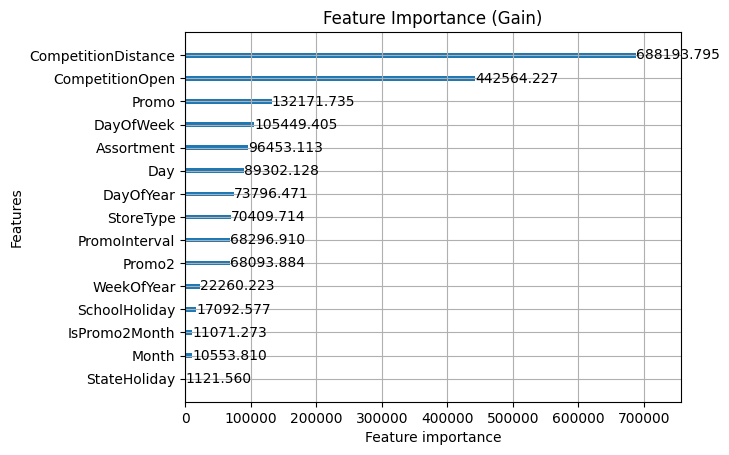

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import pickle
import os

# --- Configuration ---
MODEL_FILE = 'lgbm_model.pkl'
FEATURE_FILE = 'features.pkl'

def load_data(train_path='train.csv', test_path='test.csv', store_path='store.csv'):
    """Loads and merges the primary datasets."""
    try:
        # Load data, setting low_memory=False for large files
        train_df = pd.read_csv('train.csv', low_memory=False, dtype={"StateHoliday": str})
        test_df = pd.read_csv('test.csv', low_memory=False)
        store_df = pd.read_csv('store.csv', low_memory=False)
    except FileNotFoundError as e:
        print(f"Error: {e}. Please ensure all CSV files are in the current directory.")
        return None, None, None

    # Merge DataFrames
    train_df = train_df.merge(store_df, on="Store", how="left")
    test_df = test_df.merge(store_df, on="Store", how="left")

    # Convert Date columns
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])

    # Filter out closed stores or rows with zero sales from training data
    # This is crucial for models using log-transformed targets
    train_df = train_df[(train_df['Open'] != 0) & (train_df['Sales'] > 0)].copy()

    # Fill missing 'Open' values in test set (assume open if missing)
    test_df['Open'] = test_df['Open'].fillna(1).astype(int)

    return train_df, test_df, store_df

def feature_engineering(df):
    """Creates time-based and competition/promotion features."""

    # 1. Date Features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfWeek'] = df['Date'].dt.dayofweek

    # 2. Missing Value Imputation
    # Fill CompetitionDistance with a large value
    df['CompetitionDistance'] = df['CompetitionDistance'].fillna(df['CompetitionDistance'].max() * 2)

    # Fill NA for competition dates and Promo2 features with 0
    for col in ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear']:
        df[col] = df[col].fillna(0).astype(int)

    df['PromoInterval'] = df['PromoInterval'].fillna('None')

    # 3. Competition Open Time (in months)
    # Calculate difference in years * 12 + difference in months
    df['CompetitionOpen'] = 12 * (df['Year'] - df['CompetitionOpenSinceYear']) + \
                            (df['Month'] - df['CompetitionOpenSinceMonth'])
    df['CompetitionOpen'] = df['CompetitionOpen'].apply(lambda x: x if x > 0 else 0)

    # 4. Promo2 Status (Is the store running a Promo2 in the current month?)
    month_to_str = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                    7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df['MonthStr'] = df['Month'].map(month_to_str)

    # Check if the current month is one of the months listed in PromoInterval
    df['IsPromo2Month'] = df.apply(lambda row:
                                   row['MonthStr'] in row['PromoInterval'] if row['Promo2'] == 1 else 0,
                                   axis=1).astype(int)

    df = df.drop(columns=['MonthStr'])

    return df

def preprocess_and_train(train_df, test_df):
    """Handles encoding, final data splitting, and model training."""

    # --- Feature Engineering ---
    train_df = feature_engineering(train_df)
    test_df = feature_engineering(test_df)

    # --- Encoding Categorical Features ---
    categorical_cols = ['StoreType', 'Assortment', 'StateHoliday', 'PromoInterval']

    # Combine data for consistent LabelEncoding
    combined_data = pd.concat([train_df, test_df], ignore_index=True)

    for col in categorical_cols:
        le = LabelEncoder()
        # Fit on combined data to handle all possible values
        le.fit(combined_data[col].astype(str))

        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))

        # Cast as category for LightGBM optimization
        train_df[col] = train_df[col].astype('category')
        test_df[col] = test_df[col].astype('category')

    # --- Define Target (y) and Features (X) ---
    y = np.log1p(train_df['Sales'])

    drop_cols = [
        'Date', 'Sales', 'Customers', 'Store', 'Id', 'Open',
        'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
        'Promo2SinceWeek', 'Promo2SinceYear'
    ]

    # Filter columns to drop based on presence in the DataFrame
    train_cols_to_drop = [col for col in drop_cols if col in train_df.columns]

    X = train_df.drop(columns=train_cols_to_drop)

    # Final Feature Cleaning: Ensure only numerical/categorical features remain
    # Use the column names from X to define the features for saving
    final_features = list(X.columns)

    print(f"Total features used for training: {len(final_features)}")

    # --- LightGBM Parameters ---
    params = {
        "objective": "regression_l1",
        "metric": "rmse",
        "boosting_type": "gbdt",
        "learning_rate": 0.03,
        "num_leaves": 40,
        "feature_fraction": 0.7,
        "bagging_fraction": 0.6,
        "bagging_freq": 1,
        "verbose": -1,
        "n_jobs": -1,
        "seed": 42
    }

    # --- Training the Final Model (on all data for best performance) ---
    print("\n--- Starting Final Model Training ---")

    # We use a TimeSeriesSplit to determine the optimal number of boosting rounds
    tscv = TimeSeriesSplit(n_splits=5)
    best_iterations = []

    # Simple walk-forward validation to find average best_iteration
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        dtrain = lgb.Dataset(X_train, label=y_train)
        dval = lgb.Dataset(X_val, label=y_val)

        temp_model = lgb.train(
            params, dtrain, valid_sets=[dval], num_boost_round=5000,
            callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)]
        )
        best_iterations.append(temp_model.best_iteration)

    avg_best_iteration = int(np.mean(best_iterations))
    print(f"Average best iteration from CV: {avg_best_iteration}")

    # Train the final model using the averaged best iteration
    final_model = lgb.train(
        params,
        lgb.Dataset(X, label=y),
        num_boost_round=avg_best_iteration
    )

    print(f"Final model trained successfully on {len(X)} rows.")

    return final_model, final_features

def save_model_and_features(model, features):
    """Saves the model and the feature list using pickle."""
    with open(MODEL_FILE, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved to {MODEL_FILE}")

    with open(FEATURE_FILE, 'wb') as f:
        pickle.dump(features, f)
    print(f"Features saved to {FEATURE_FILE}")

if __name__ == "__main__":
    train_df, test_df, store_df = load_data()

    if train_df is not None:
        final_model, final_features = preprocess_and_train(train_df, test_df)
        save_model_and_features(final_model, final_features)

        # Display Feature Importance
        lgb.plot_importance(final_model, max_num_features=15, importance_type='gain', title='Feature Importance (Gain)')
        plt.tight